# **EPS Meteograms**
<a href="https://githubtocolab.com/csteele2/Wx4Colab/blob/master/EPS_Meteograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a> <br/>

This notebook uses the [ECMWF OpenData API](https://pypi.org/project/ecmwf-opendata/) to efficiently download EPS from [ECMWF OpenData](https://www.ecmwf.int/en/forecasts/datasets/open-data) (0.4 degree data) into a [zarr](https://zarr.readthedocs.io/en/stable/) (for efficient memory usage). Then uses the [Synoptic Data metadata API](https://developers.synopticdata.com/mesonet/v2/stations/metadata/) to locate a station, and [seaborn](https://seaborn.pydata.org) to make ensemble meteograms.

> 5-Feb-2023: Initial release with improvements over the Herbie version with both data handling and improved plots.



- Caleb Steele, https://github.com/csteele2/Wx4Colab

##**1 - Install CondaColab**
This will manage the installation of the packages we need, like [Herbie](https://blaylockbk.github.io/Herbie/_build/html/index.html). <br />**NOTE**: this will restart the notebook, and you will get a crash popup in the lower-left corner that you can safely ignore

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:43
🔁 Restarting kernel...


##**2 - Install and Import Packages**
This will take about a minute to run.

In [2]:
!mamba install -q -c conda-forge cfgrib matplotlib seaborn xarray zarr tqdm
!pip install ecmwf-opendata
import matplotlib # to make plots, duh
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects # to add outline to text, etc.
import matplotlib.patches as mpatches # to make better-looking legends instead of ugly colorbars
from ecmwf.opendata import Client # to get EPS data
import seaborn as sns # to easily make ensemble meteograms via heatmaps (chicklets) and box plots
from datetime import datetime, timedelta
import xarray as xr # to make hypercubes
import numpy as np
import pandas as pd # to organize point data
import requests # to get station meta data (location) [optional]
import json # to read station metadata [optional]
import os # to help clean up
import glob # to help clean up
from tqdm.notebook import tqdm # to show progress and minimize printed output


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.0.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

  Package                        Version  Build                Channel                   Size
────────────────────

##**3 - Download Data**
This will download global ensemble data then store it in a zarr (xarray) object [this enables us to quickly slice and dice the data in any dimension without reading it all into memory]. It will process a large amount of data, so **it will take 20-30+ minutes to run**.

In [9]:
#@title Download Data | Options { display-mode: "form" }
#@markdown <b> 3a. Choose Source </b> <br />
#@markdown &nbsp; &nbsp; &nbsp; &nbsp; --> ECMWF is fastest, best for near-real time. <br />
#@markdown &nbsp; &nbsp; &nbsp; &nbsp; --> Azure is usually slower, but has a longer archive. 
source = "ecmwf" #@param ["ecmwf", "azure"]
#@markdown <br/> <b> 3b. Choose Model Run </b> <br />
model_initialization = "2023-02-05" #@param {type:"date"}
model_cycle = 0 #@param [0, 6, 12, 18] {type:"raw"}
model_run = datetime.strptime(model_initialization,'%Y-%m-%d') + timedelta(hours = model_cycle)


forecast_hour_start = 0
if model_cycle == 0 or model_cycle == 12:
  forecast_hour_interval = 6
  forecast_hour_end = 240
else:
  forecast_hour_interval = 3
  forecast_hour_end = 144




###########################################################################
forecast_hours = list(range(forecast_hour_start, forecast_hour_end + forecast_hour_interval, forecast_hour_interval))
forecast_list = tqdm(range(forecast_hour_start, forecast_hour_end + forecast_hour_interval, forecast_hour_interval))
valid_times = [model_run+timedelta(hours=v) for v in forecast_hours]
zarr_file = f"eps_{model_run.strftime('%Y%m%d%H')}.zarr"

def get_eps():
  client = Client(source=source)
  for t in forecast_list:
      forecast_list.set_description(f"Downloading Data: (FH{t}/{forecast_hour_end})")
      request = {
          'date':model_run,
          'step':t,
          'stream':"enfo",
          'type':["cf","pf"],
          'param':["2t","tp"],
          'target':"tmp.grib2",
      }

      client.retrieve(request)
      pf_dataset = xr.open_dataset("tmp.grib2", engine='cfgrib', backend_kwargs={'filter_by_keys':{'dataType':'pf'}})
      cf_dataset = xr.open_dataset("tmp.grib2", engine='cfgrib', backend_kwargs={'filter_by_keys':{'dataType':'cf'}})
      dataset = xr.concat([cf_dataset, pf_dataset], dim='number')
      dataset = dataset.expand_dims({'step':1})
      #dataset = dataset.sel(longitude=slice(-180,-30), latitude=slice(85,5))
      if t == forecast_hour_start:
          dataset.to_zarr(store=zarr_file, mode='w')
      else:
          dataset.to_zarr(store=zarr_file, mode='a', append_dim='step')

      try:
          os.remove('tmp.grib2')
          indexfiles = glob.glob('tmp.grib2.*.idx', recursive=True)
          for indexfile in indexfiles:
              os.remove(indexfile)
      except:
          pass

get_eps()
ecmwfe = xr.open_zarr(zarr_file)

  0%|          | 0/41 [00:00<?, ?it/s]

20230205000000-0h-enfo-ef.grib2:   0%|          | 0.00/29.6M [00:00<?, ?B/s]

20230205000000-6h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-12h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-18h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-24h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-30h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-36h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-42h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-48h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-54h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-60h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-66h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-72h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-78h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-84h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-90h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-96h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-102h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-108h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-114h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-120h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-126h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-132h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-138h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-144h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-150h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-156h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-162h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-168h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-174h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-180h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-186h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-192h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-198h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-204h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-210h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-216h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-222h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-228h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-234h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

20230205000000-240h-enfo-ef.grib2:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

##**4 - Make Plots**
This will extract values for you chosen station/point, and, if you selected a bucket precipitation, derive it from the total precipitation that is downloaded. The plot will display below and also save to a png if you click on the folder icon on the left bar.

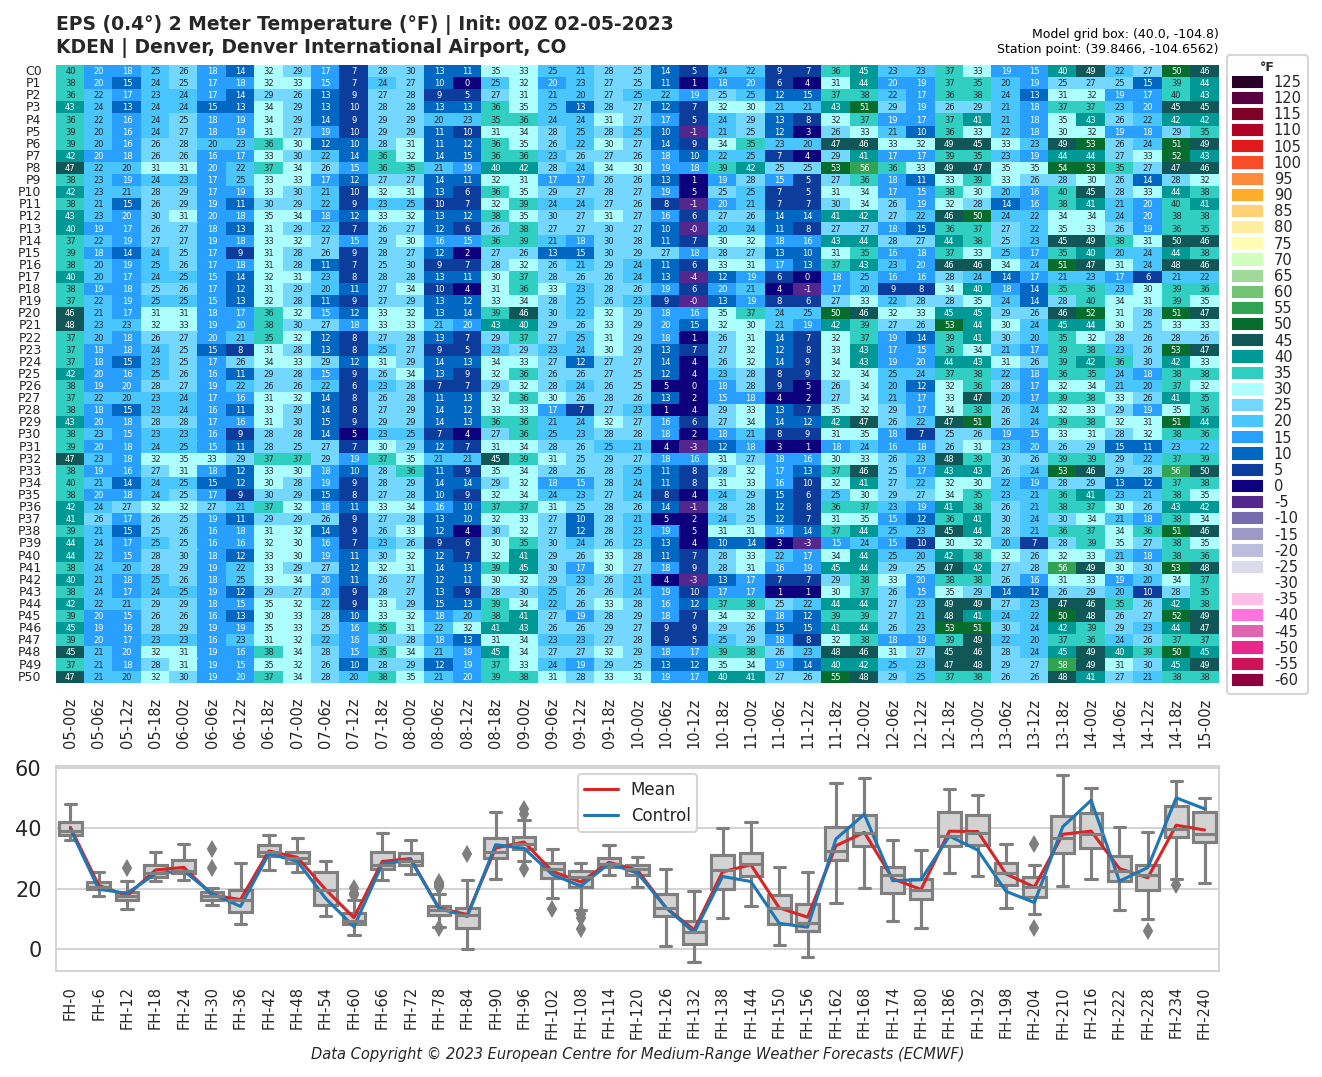

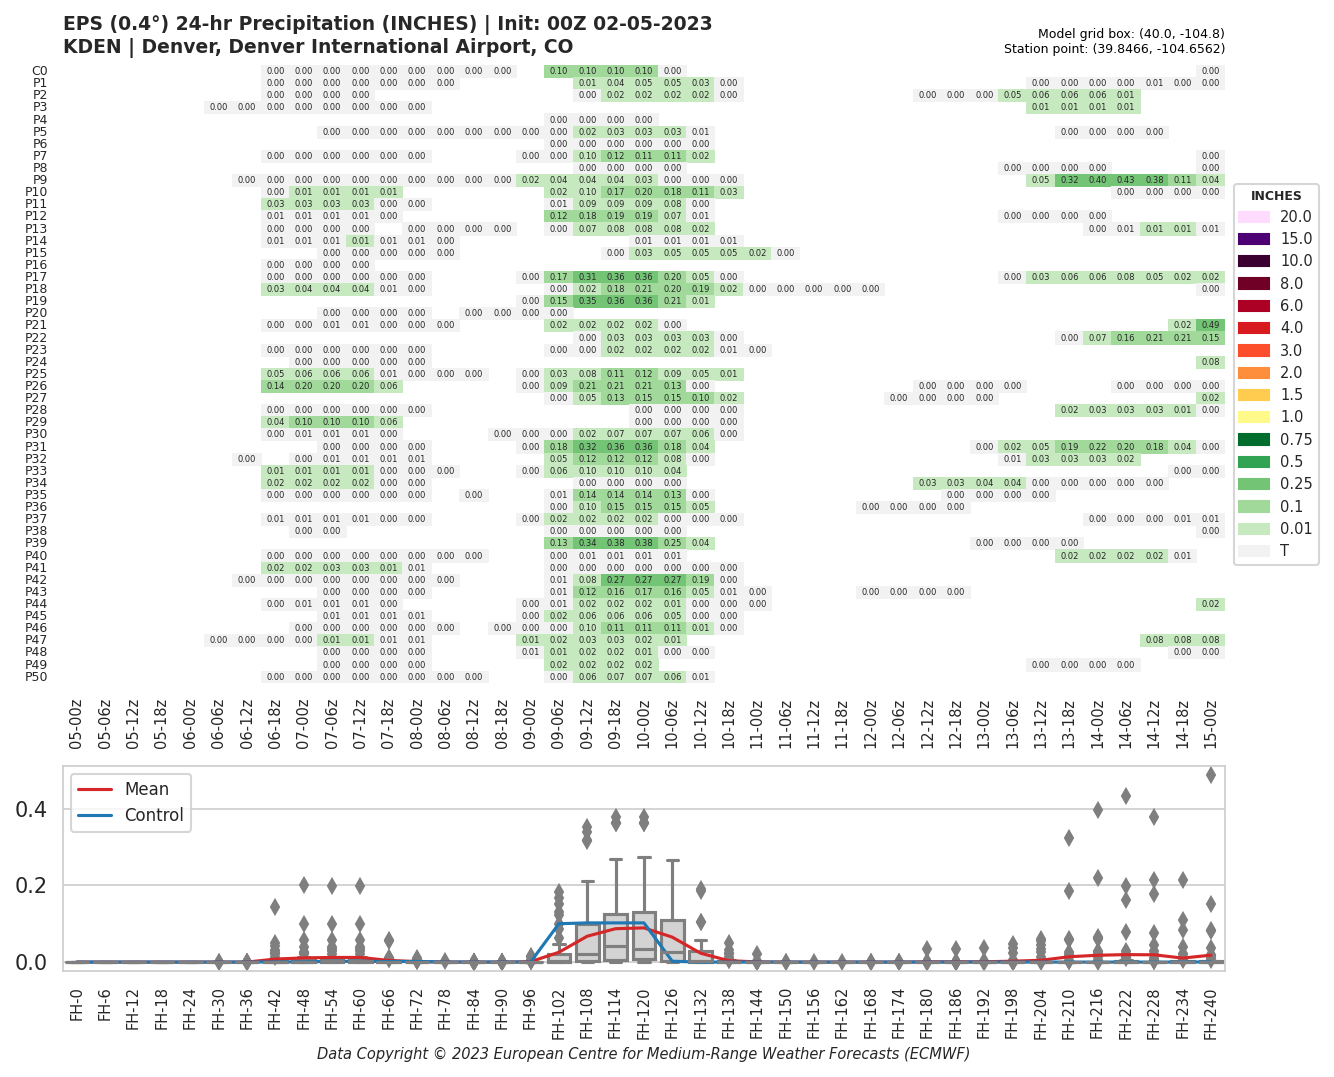

In [32]:
#@title Make Plot | Options { display-mode: "form" }
site_id = "KDEN" #@param {type:"string"}
synoptic_token = ""#@param {type:"string"}
#@markdown Choose what precipitation you want
precipitation_selection = 24 #@param [6, 24, 48, 72, "Run Total"] {type:"raw"}
unit_system = "imperial" #@param ["metric", "imperial"]


###########################################################
###########################################################


def get_stn_meta(sid):
  """ Use the synoptic data API to get metadata for a station by id """
  site_dict = {}
  meta_api = "https://api.synopticlabs.org/v2/stations/metadata"
  req_parms = {"token":synoptic_token,
                 "stid":site_id,
                 "fields": "latitude,longitude,name,state"
                 }
  req_meta = requests.get(meta_api, req_parms)
  meta_json = json.loads(req_meta.text)
  for stn in meta_json["STATION"]:
      if float(stn["LATITUDE"]) != 0. and float(stn["LONGITUDE"]) != 0.:
          site_dict['lat'] = float(stn["LATITUDE"])
          site_dict['lon'] = float(stn["LONGITUDE"])
          site_dict['name'] = stn["NAME"]
          if stn["STATE"]=="":
            if len(stn["STID"]) == 4:
              if stn["STID"][0]=="N":
                site_dict['state'] = "New Zealand"
          else:
            site_dict['state'] = stn["STATE"]
      
  return site_dict

site_dict = get_stn_meta(site_id)

def get_nearest_loc(mlats, mlons):
  point_lat = site_dict['lat']
  point_lon = site_dict['lon']
  latidx = np.abs(mlats - point_lat).argmin()
  lonidx = np.abs(mlons - point_lon).argmin()
  return(mlats[latidx], mlons[lonidx])

def m_to_in(meters):
  inches = meters * 39.3701
  return inches

def m_to_mm(meters):
  inches = meters * 1000.
  return inches

def K_to_F(kelvin):
  F = 1.8*(kelvin-273.15) + 32
  return F

def K_to_C(kelvin):
  C = kelvin-273.15
  return C

QPF_COLS = ["#f2f2f2", "#c7e9c0","#a1d99b", "#74c476", "#31a353", "#006d2c", "#fff98a", "#ffcc4f", 
            "#fe8d3c", "#fc4e2a", "#d61a1d", "#ad0025", "#700025", "#3b0030", "#4d0073", "#ffdbff"]
QPF_LEVS = [0.0, 0.01,0.10,0.25,0.50,0.75,1.0,1.5,2.0,3.0,4.0,6.0,8.0,10.0,15.0,20.0]
QPF_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('NWS_Standard_QPF_Modified', QPF_COLS, N=len(QPF_LEVS))
norm_qpf = matplotlib.colors.BoundaryNorm(QPF_LEVS, len(QPF_LEVS))


T_COLS = [
            "#91003e","#ce1257","#e7298b","#df65b0","#ff73df",
            "#ffbee8","#ffffff","#dadaeb","#bcbddc","#9e9ac8",
            "#766bb1","#54278f","#0c007d","#0d3d9c","#0067c2",
            "#299fff","#4ac6ff","#73d7ff","#adffff","#30cfc2",
            "#009996","#125757","#066d2c","#31a353","#74c477",
            "#a1d99b","#d3ffbe","#ffffb3","#ffeea0","#fed176",
            "#fead2a","#fd8c3c","#fc4d2a","#e31a1d","#b10026",
            "#800026","#590041","#280028"
        ]

T_LEVS = np.arange(-60,130,5)
T_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('NWS_Standard_QPF_Modified', T_COLS, N=len(T_LEVS))
norm_t = matplotlib.colors.BoundaryNorm(T_LEVS, len(T_LEVS))

sns.set_style("whitegrid")


#################################################################


def plot_pcp_bucket(bucket):
    apcp = pd.DataFrame(ecmwfe.sel(latitude=nearest_lat, longitude=nearest_lon).tp.values)
    apcp = apcp.T
    pbucket = apcp.copy()
    
    bucket_step_width = int(bucket / forecast_hour_interval)
    for col in range(bucket_step_width,len(pbucket.columns)):
        pbucket.iloc[:,col] = apcp.iloc[:,col] - apcp.iloc[:,(col-bucket_step_width)]
    
    if unit_system == "metric":
      pcp_annot = m_to_mm(pbucket.copy())
      pbucket[pbucket<=0.] = np.nan
      pbucket = m_to_in(pbucket)
      units = "mm"
      
    else:
      pbucket = m_to_in(pbucket)
      pbucket[pbucket<=0.] = np.nan
      pcp_annot = pbucket
      units = "INCHES"

    control = pcp_annot.fillna(0).iloc[0]
    mean = pcp_annot.fillna(0).mean(axis=0)
    box_data = pd.melt(pcp_annot.fillna(0))

    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,8), gridspec_kw={'height_ratios': [3, 1]}, dpi=150)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

    title = "EPS (0.4°) %s-hr Precipitation (%s) | Init: %s\n%s | %s, %s" % (bucket, units, model_run.strftime('%HZ %m-%d-%Y'), site_id, sitename, state)
    plt.text(1.00,1.02,"Model grid box: %s\nStation point: %s" % (model_latlon, request_latlon),horizontalalignment='right',fontsize=6,color='k',transform = ax1.transAxes)
    ax1.set_title(title,fontsize=9, weight='bold', stretch='normal', family='sans-serif', loc='left',color='#272727')
    heatmap = sns.heatmap(pbucket, yticklabels=[i+j for (i,j) in zip(['C'] + ['P']*50, np.arange(0,51).astype(str))], xticklabels=[valid_times[v].strftime('%d-%Hz') for v in range(0,len(valid_times))], 
                cmap=QPF_cmap, annot=pcp_annot, fmt=".2f", annot_kws={"fontsize":4}, norm=norm_qpf, cbar=False, ax=ax1)
    ax1.set_yticklabels(ax1.get_ymajorticklabels(), fontsize = 6)
    ax1.set_xticklabels(ax1.get_xmajorticklabels(), fontsize = 7)
    proxy = [mpatches.Patch(color = QPF_COLS[b]) for b in range(len(QPF_LEVS))]
    proxy = proxy[::-1]
    LLABS = []
    for i in range(0, len(QPF_LEVS)):
      if QPF_LEVS[i] == 0.0:
        label = "T"
      else:
        if unit_system == "metric":
          label = str(round(QPF_LEVS[i]*25.4,1))
        else:
          label = str(QPF_LEVS[i])
      LLABS.append(label)
    LLABS = LLABS[::-1]
    l = ax1.legend(handles=proxy, labels=LLABS, fontsize=7, frameon=True, bbox_to_anchor=(1.001, 0.5), loc=6, title=units)
    plt.setp(l.get_title(), fontsize=6, weight='bold')

    for row in range(0,box_data[box_data.columns[0]].count()):
        box_data.iloc[row,0] = forecast_hours[box_data.iloc[row,0]]
    sns.boxplot(x="variable", y="value",data=box_data,ax=ax2,color='lightgrey')
    ax2.plot(mean, linewidth=1.5, color="tab:red", label='Mean')
    ax2.plot(control, linewidth=1.5, color="tab:blue", label='Control')
    ax2.legend(fontsize=8)
    ax2.set(ylabel=None)
    #ax2.set(ylabel=f"{bucket}-hr Precip ({units})")
    ax2.set_xticklabels(labels=[f"FH-{x}" for x in forecast_hours], fontsize = 7, rotation=90)
    ax2.set_xlabel(f"Data Copyright © {model_run.strftime('%Y')} European Centre for Medium-Range Weather Forecasts (ECMWF)", fontsize=7, style="italic")
    plt.savefig(f"EPS_{model_run.strftime('%Y%m%d-%H')}_pcp{bucket}_{site_id}", bbox_inches='tight')


def plot_pcp_total():
    apcp = pd.DataFrame(ecmwfe.sel(latitude=nearest_lat, longitude=nearest_lon).tp.values)
    apcp = apcp.T

    if unit_system == "metric":
      pcp_annot = m_to_mm(apcp.copy())
      apcp[apcp<=0.] = np.nan
      apcp = m_to_in(apcp)
      units = "mm"
      
    else:
      apcp = m_to_in(apcp)
      apcp[apcp<=0.] = np.nan
      pcp_annot = apcp
      units = "INCHES"

    control = pcp_annot.fillna(0).iloc[0]
    mean = pcp_annot.fillna(0).mean(axis=0)
    box_data = pd.melt(pcp_annot.fillna(0))

    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,8), gridspec_kw={'height_ratios': [3, 1]}, dpi=150)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

    title = "EPS (0.4°) Total Precipitation (%s) | Init: %s\n%s | %s, %s" % (units, model_run.strftime('%HZ %m-%d-%Y'), site_id, sitename, state)
    plt.text(1.00,1.02,"Model grid box: %s\nStation point: %s" % (model_latlon, request_latlon),horizontalalignment='right',fontsize=6,color='k',transform = ax1.transAxes)
    heatmap = sns.heatmap(apcp, yticklabels=[i+j for (i,j) in zip(['C'] + ['P']*50, np.arange(0,51).astype(str))], xticklabels=[valid_times[v].strftime('%d-%Hz') for v in range(0,len(valid_times))], 
                cmap=QPF_cmap, annot=pcp_annot, fmt=".2f", annot_kws={"fontsize":4}, norm=norm_qpf, cbar=False, ax=ax1)
    ax1.set_yticklabels(ax1.get_ymajorticklabels(), fontsize = 6)
    ax1.set_xticklabels(ax1.get_xmajorticklabels(), fontsize = 7)

    proxy = [mpatches.Patch(color = QPF_COLS[b]) for b in range(len(QPF_LEVS))]
    proxy = proxy[::-1]
    LLABS = []
    for i in range(0, len(QPF_LEVS)):
      if QPF_LEVS[i] == 0.0:
        label = "T"
      else:
        if unit_system == "metric":
          label = str(round(QPF_LEVS[i]*25.4,1))
        else:
          label = str(QPF_LEVS[i])
      LLABS.append(label)
    LLABS = LLABS[::-1]
    l = ax1.legend(handles=proxy, labels=LLABS, fontsize=7, frameon=True, bbox_to_anchor=(1.001, 0.5), loc=6, title=units)
    plt.setp(l.get_title(), fontsize=6, weight='bold')
    
    for row in range(0,box_data[box_data.columns[0]].count()):
        box_data.iloc[row,0] = forecast_hours[box_data.iloc[row,0]]
    sns.boxplot(x="variable", y="value",data=box_data,ax=ax2,color='lightgrey')
    ax2.plot(mean, linewidth=1.5, color="tab:red", label='Mean')
    ax2.plot(control, linewidth=1.5, color="tab:blue", label='Control')
    ax2.legend(fontsize=8)
    ax2.set(ylabel=None)
    ax2.set_xticklabels(labels=[f"FH-{x}" for x in forecast_hours], fontsize = 7, rotation=90)
    #ax2.set(ylabel=f"Total Precip ({units})")
    ax2.set_xlabel(f"Data Copyright © {model_run.strftime('%Y')} European Centre for Medium-Range Weather Forecasts (ECMWF)", fontsize=7, style="italic")
    plt.savefig(f"EPS_{model_run.strftime('%Y%m%d-%H')}_ptotal_{site_id}", bbox_inches='tight')


def plot_t2m():
    t2m = pd.DataFrame(ecmwfe.sel(latitude=nearest_lat, longitude=nearest_lon).t2m.values)
    t2m = t2m.T

    if unit_system == "metric":
      t2m_annot = K_to_C(t2m)
      t2m = K_to_F(t2m)
      units = "°C"
      control = t2m_annot.iloc[0]
      mean = t2m_annot.mean(axis=0)
    else:
      t2m = K_to_F(t2m)
      t2m_annot = t2m
      units = "°F"

    box_data = pd.melt(t2m_annot)
    control = t2m_annot.iloc[0]
    mean = t2m_annot.mean(axis=0)

    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,8), gridspec_kw={'height_ratios': [3, 1]}, dpi=150)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

    title = "EPS (0.4°) 2 Meter Temperature (%s) | Init: %s \n%s | %s, %s" % (units, model_run.strftime('%HZ %m-%d-%Y'), site_id, sitename, state)
    plt.text(1.00,1.02,"Model grid box: %s\nStation point: %s" % (model_latlon, request_latlon),horizontalalignment='right',fontsize=6,color='k',transform = ax1.transAxes)
    ax1.set_title(title,fontsize=9, weight='bold', stretch='normal', family='sans-serif', loc='left',color='#272727')
    sns.heatmap(t2m, yticklabels=["C0"]+[f"P{i}" for i in range (1,51)], xticklabels=[valid_times[v].strftime('%d-%Hz') for v in range(0,len(valid_times))], 
                cmap=T_cmap, annot=t2m_annot, fmt=".0f", annot_kws={"fontsize":4}, norm=norm_t, cbar=False, ax=ax1)
    ax1.set_yticklabels(ax1.get_ymajorticklabels(), fontsize = 6)
    ax1.set_xticklabels(ax1.get_xmajorticklabels(), fontsize = 7)

    proxy = [mpatches.Patch(color = T_COLS[b]) for b in range(len(T_LEVS))]
    proxy = proxy[::-1]
    LLABS = []
    for i in range(0, len(T_LEVS)):
      if unit_system=="metric":
        label = str(round(((T_LEVS[i]-32.) * (5./9.))))
      else:
        label = str(T_LEVS[i])
      LLABS.append(label)
    LLABS = LLABS[::-1]
    l = ax1.legend(handles=proxy, labels=LLABS, fontsize=7, frameon=True, bbox_to_anchor=(1.001, 0.5), loc=6, title=units, labelspacing=0.08)
    plt.setp(l.get_title(), fontsize=6, weight='bold')
    
    for row in range(0,box_data[box_data.columns[0]].count()):
        box_data.iloc[row,0] = forecast_hours[box_data.iloc[row,0]]
    #sns.violinplot(x="variable", y="value", data=box_data, ax=ax2, cut=0, scale="count", inner="box", color='lightgrey')
    sns.boxplot(x="variable", y="value",data=box_data,ax=ax2,color='lightgrey', showmeans=False)
    ax2.plot(mean, linewidth=1.5, color="tab:red", label='Mean')
    ax2.plot(control, linewidth=1.5, color="tab:blue", label='Control')
    ax2.legend(fontsize=8)
    ax2.set(ylabel=None)
    ax2.set_xticklabels(labels=[f"FH-{x}" for x in forecast_hours], fontsize = 7, rotation=90)
    #ax2.set_yticklabels(ax2.get_yticklabels(), fontsize = 7)
    #ax2.set_ylabel(f"2m Temp ({units})", fontsize=9)
    ax2.set_xlabel(f"Data Copyright © {model_run.strftime('%Y')} European Centre for Medium-Range Weather Forecasts (ECMWF)", fontsize=7, style="italic")
    plt.savefig(f"EPS_{model_run.strftime('%Y%m%d-%H')}_t2m_{site_id}", bbox_inches='tight')

#########################################################################

nearest_lat, nearest_lon = get_nearest_loc(ecmwfe.latitude.values, ecmwfe.longitude.values)
request_latlon = f"({round(site_dict['lat'],4)}, {round(site_dict['lon'], 4)})"
model_latlon = f"({round(nearest_lat,4)}, {round(nearest_lon,4)})"
sitename = site_dict['name']
state = site_dict['state']

plot_t2m()

if precipitation_selection != "Run Total":
  plot_pcp_bucket(precipitation_selection)
else:
  plot_pcp_total()


